# Santiago de Chile neighborhood analysis

## Introduction

When the COVID-19 pandemic ends, a lot of people will feel the rush to go outside, use parks, eat at restaurants, check museums, go to bars with friends and meet people at coffee shops. The thing is, the most popular zones will experience a big influx of people, so getting a table in your favorite bar will be difficult on a Saturday night, or maybe you just want to try something new.

Santiago is the biggest city of Chile, there are many places where you could go, you just  don't know them. If you can't go to Providencia, one the best places to go get a drink or grab a bite, you could search for similar neighborhoods to that one, so you can fulfill your plans and try something new, and trying new things is always exiting.

The scope of this project is the following: for each neighborhood in Santiago de Chile, check the most common type of places of interest, rank them by occurrence and place a marker on a map with that information. The next step is clustering the different neighborhoods into similar ones based on the type of the places of interest, that way you can choose a substitute based on what you want.

You like Neighborhood X because it has a lot of places to eat and cultural landmarks, but you don't want to go again to the same places you are used to? No problem, check what neighborhoods are similar and give them a try!

## The Data

First, we need the Postal Codes of the neighborhoods of Santiago and we will scrap them from https://es.wikipedia.org/wiki/Anexo:C%C3%B3digos_postales_de_Chile, there is a table with every Postal Code of every neighborhood in Chile, so we will need to filter after the scrapping. Postal Codes between 7000000 and 8999999 correspond to nighborhoods inside the Metropolitan Area of Santiago, so we will use those.

Using geolocator library, we will get the Latitude and Longitude for every neighborhood and add them to the dataset, that way we hace the neighborhood with the associated coordinates.

With the Foursquare API, the venues of interest will be requested and added to a new dataframe, where they will be one hot encoded, grouped by neighborhood and standardized, so a clustering algorithm may be applied.

In [92]:
# Importing and installing every package needed.

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

!pip install geocoder
!pip install folium

# Library to handle JSON files
import json

# Convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# Library to handle requests
import requests

# Tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Import k-means from clustering stage
from sklearn.cluster import KMeans

# Map rendering library
import folium 

In [81]:
# Web scrapping
req = requests.get("https://es.wikipedia.org/wiki/Anexo:C%C3%B3digos_postales_de_Chile")

soup = BeautifulSoup(req.content,'lxml')

table = soup.find_all('table')[0]

df = pd.read_html(str(table))

chile_pc = pd.DataFrame(df[0])

In [82]:
print('Dataset looks like this:')
chile_pc.head()

Dataset looks like this:


,Comuna/localidad,Código
0,Algarrobo,2710000
1,Alhué,9650000
2,Alto Biobío,4590000
3,Alto del Carmen,1650000
4,Alto Hospicio,1130000


In [83]:
print('Shape of the dataset:')
print(chile_pc.shape)

Shape of the dataset:
(344, 2)


In [85]:
# Make a list with all the neighborhoods name
list_of_nh = chile_pc['Neighborhood'].to_list()

# Add a CL to the neighborhood name, but is that neighborhood is Santiago, then add a CH
# This is for finding latitude and longitude with Geolocator Nominatim, and for some reason 'Santiago, CL' does not find the correct coordinates, but 'Santiago, CH does'
for i in range(0,len(list_of_nh)):
    if list_of_nh[i] == 'Santiago':
        chile_pc.at[i,'Neighborhood'] = list_of_nh[i] + ', CH'
    else:
        chile_pc.at[i,'Neighborhood'] = list_of_nh[i] + ', CL'
        
print('Resulting Dataset:')
chile_pc

Resulting Dataset:


,Neighborhood,PostalCode
0,"Conchalí, CL",8540000
1,"El Bosque, CL",8010000
2,"Huechuraba, CL",8580000
3,"Independencia, CL",8380000
4,"La Cisterna, CL",7970000
5,"La Florida, CL",8240000
6,"La Granja, CL",8780000
7,"La Pintana, CL",8820000
8,"La Reina, CL",7850000
9,"Las Condes, CL",7550000


In [86]:
# Making empty lists for latitude and longitude
lat_list=[]
lon_list=[]

# Updating list with name of all neighborhoods fot geolocator search
list_of_nh = chile_pc['Neighborhood'].to_list()

# Getting every neighborhood's coordinates and adding them to they respective coordinates
# Printing both coordinates and lists to make sure they are correct and saved in the lists
for i in list_of_nh:
    address = i
    geolocator = Nominatim(user_agent="santiago_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of ', i, ' are {}, {}.'.format(latitude, longitude))
    lat_list.append(latitude)
    lon_list.append(longitude)
    
print('\n', 'Latitude List:', lat_list)
print('\n', 'Longitude List', lon_list)

The geograpical coordinate of  Conchalí, CL  are -33.384775149999996, -70.67460576456799.
The geograpical coordinate of  El Bosque, CL  are -33.56235185, -70.67681955928742.
The geograpical coordinate of  Huechuraba, CL  are -33.365721449999995, -70.6429271186091.
The geograpical coordinate of  Independencia, CL  are -33.416411749999995, -70.66581795393661.
The geograpical coordinate of  La Cisterna, CL  are -33.5295218, -70.66425289405431.
The geograpical coordinate of  La Florida, CL  are -33.530714450000005, -70.54402715938959.
The geograpical coordinate of  La Granja, CL  are -33.53587875, -70.62229522259899.
The geograpical coordinate of  La Pintana, CL  are -33.591388550000005, -70.63642326010053.
The geograpical coordinate of  La Reina, CL  are -33.44737295, -70.53341181233888.
The geograpical coordinate of  Las Condes, CL  are -33.4247879, -70.51749760753927.
The geograpical coordinate of  Lo Barnechea, CL  are -33.2935888, -70.39035501440654.
The geograpical coordinate of  Lo 

In [87]:
# Adding the Latitude and Longitude to the dataframe using the created lists
chile_pc['Latitude'] = lat_list
chile_pc['Longitude'] = lon_list

print('Resulting Dataset:')
chile_pc

Resulting Dataset:


,Neighborhood,PostalCode,Latitude,Longitude
0,"Conchalí, CL",8540000,-33.384775,-70.674606
1,"El Bosque, CL",8010000,-33.562352,-70.676820
2,"Huechuraba, CL",8580000,-33.365721,-70.642927
3,"Independencia, CL",8380000,-33.416412,-70.665818
4,"La Cisterna, CL",7970000,-33.529522,-70.664253
5,"La Florida, CL",8240000,-33.530714,-70.544027
6,"La Granja, CL",8780000,-33.535879,-70.622295
7,"La Pintana, CL",8820000,-33.591389,-70.636423
8,"La Reina, CL",7850000,-33.447373,-70.533412
9,"Las Condes, CL",7550000,-33.424788,-70.517498


In [88]:
# Create map of Santiago City centered in the Santiago neighborhood
latitude = chile_pc.at[26,'Latitude']
longitude = chile_pc.at[26,'Longitude']
map_stgo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(chile_pc['Latitude'], chile_pc['Longitude'], chile_pc['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stgo)  
    
map_stgo

Las Condes, Lo Barnechea, Peñalolén and La Florida seem very far away, because those are incredibly huge with rural areas nighborhoods they centers will look like outside or on the border of the city.


I will move all of them manually, so the map makes sense. I will use each neighborhood Municipality as new center point

In [ ]:
address = i
geolocator = Nominatim(user_agent="santiago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
lat_list.append(latitude)
lon_list.append(longitude)

In [19]:
# Updating La Florida coordinates to the Lo Barnechea Municipality
chile_pc.at[5,'Latitude'] = -33.5587812
chile_pc.at[5,'Longitude'] = -70.5891141

# Updating Las Condes coordinates to the Las Condes Municipality
chile_pc.at[9,'Latitude'] = -33.4079488
chile_pc.at[9,'Longitude'] = -70.5451132

# Updating Lo Barnechea coordinates to the Lo Barnechea Municipality
chile_pc.at[10,'Latitude'] = -33.3534679
chile_pc.at[10,'Longitude'] = -70.5222244

# Updating Peñalolén coordinates to the Lo Barnechea Municipality
chile_pc.at[15,'Latitude'] = -33.4764817
chile_pc.at[15,'Longitude'] = -70.5445814

In [20]:
chile_pc

,Neighborhood,PostalCode,Latitude,Longitude
0,"Conchalí, CL",8540000,-33.384775,-70.674606
1,"El Bosque, CL",8010000,-33.562352,-70.676820
2,"Huechuraba, CL",8580000,-33.365721,-70.642927
3,"Independencia, CL",8380000,-33.416412,-70.665818
4,"La Cisterna, CL",7970000,-33.529522,-70.664253
5,"La Florida, CL",8240000,-33.558781,-70.589114
6,"La Granja, CL",8780000,-33.535879,-70.622295
7,"La Pintana, CL",8820000,-33.591389,-70.636423
8,"La Reina, CL",7850000,-33.447373,-70.533412
9,"Las Condes, CL",7550000,-33.407949,-70.545113


In [22]:
# Create map of Santiago City centered in the Santiago neighborhood
latitude = chile_pc.at[26,'Latitude']
longitude = chile_pc.at[26,'Longitude']
map_stgo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(chile_pc['Latitude'], chile_pc['Longitude'], chile_pc['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stgo)  
    
map_stgo

Now that the locations are fixed, we can continue

In [24]:
#@hidden_cell
# Foursquare credentials
CLIENT_ID = 'JZGYNFOYT4J24NPR5XYHN1OFOHA53FG1J1VXG43JS1MDW0PO' # your Foursquare ID
CLIENT_SECRET = '20JWSCGWU5MV0LQOPTPGGB2LCPMBMLKHFHGXFG0AHPDWXZ00' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [25]:
# Funtion to get nearby venues
LIMIT = 100 # Limit of number of venues returned by Foursquare API

radius = 500 # Define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
# Get nearby venues for Santiago
santiago_venues = getNearbyVenues(names=chile_pc['Neighborhood'],
                                   latitudes=chile_pc['Latitude'],
                                   longitudes=chile_pc['Longitude']
                                  )

Conchalí, CL
El Bosque, CL
Huechuraba, CL
Independencia, CL
La Cisterna, CL
La Florida, CL
La Granja, CL
La Pintana, CL
La Reina, CL
Las Condes, CL
Lo Barnechea, CL
Lo Prado, CL
Macul, CL
Ñuñoa, CL
Pedro Aguirre Cerda, CL
Peñalolén, CL
Providencia, CL
Puente Alto, CL
Quilicura, CL
Quinta Normal, CL
Recoleta, CL
Renca, CL
San Bernardo, CL
San Joaquín, CL
San Miguel, CL
San Ramón, CL
Santiago, CH
Vitacura, CL


In [27]:
# Check the created dataframe
print(santiago_venues.shape)
santiago_venues.head()

(400, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Conchalí, CL",-33.384775,-70.674606,Emporio del Sushi,-33.384023,-70.670111,Sushi Restaurant
1,"Conchalí, CL",-33.384775,-70.674606,"Botillería El Pasó ""Carlitos""",-33.383643,-70.672666,Liquor Store
2,"Conchalí, CL",-33.384775,-70.674606,Amasanderia Raulito,-33.382179,-70.672045,Bakery
3,"Conchalí, CL",-33.384775,-70.674606,Estación Metro Vivaceta,-33.385419,-70.679264,Metro Station
4,"Conchalí, CL",-33.384775,-70.674606,Pedro Fontova 4299,-33.387733,-70.671069,Grocery Store


In [28]:
# Check how many per neighborhood
santiago_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Conchalí, CL",6,6,6,6,6,6
"El Bosque, CL",4,4,4,4,4,4
"Independencia, CL",9,9,9,9,9,9
"La Cisterna, CL",14,14,14,14,14,14
"La Florida, CL",11,11,11,11,11,11
"La Granja, CL",7,7,7,7,7,7
"La Reina, CL",6,6,6,6,6,6
"Las Condes, CL",30,30,30,30,30,30
"Lo Barnechea, CL",15,15,15,15,15,15


In [30]:
# Check how many unique categories
print('There are {} uniques categories.'.format(len(santiago_venues['Venue Category'].unique())))

There are 127 uniques categories.


In [31]:
# one hot encoding
santiago_onehot = pd.get_dummies(santiago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
santiago_onehot['Neighborhood'] = santiago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [santiago_onehot.columns[-1]] + list(santiago_onehot.columns[:-1])
santiago_onehot = santiago_onehot[fixed_columns]

santiago_onehot.head()

,Yoga Studio,Accessories Store,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bakery,...,Sports Bar,Stables,Supermarket,Sushi Restaurant,Tailor Shop,Tapas Restaurant,Theater,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Check shape
santiago_onehot.shape

(400, 127)

In [50]:
# group by neighborhood and use the mean of occurrence for each type of venue
santiago_grouped = santiago_onehot.groupby('Neighborhood').mean().reset_index()
santiago_grouped

,Neighborhood,Yoga Studio,Accessories Store,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,...,Sports Bar,Stables,Supermarket,Sushi Restaurant,Tailor Shop,Tapas Restaurant,Theater,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wings Joint
0,"Conchalí, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
1,"El Bosque, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
2,"Independencia, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
3,"La Cisterna, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
4,"La Florida, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
5,"La Granja, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.142857,0.000000,0.142857,0.000000,0.000000,0.0000
6,"La Reina, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
7,"Las Condes, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,...,0.033333,0.0,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.0000
8,"Lo Barnechea, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.0,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
9,"Lo Prado, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625


In [51]:
# top 5 venue types per neighborhood
num_top_venues = 5

for hood in santiago_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = santiago_grouped[santiago_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Conchalí, CL----
              venue  freq
0     Metro Station  0.17
1     Grocery Store  0.17
2      Liquor Store  0.17
3  Sushi Restaurant  0.17
4            Bakery  0.17


----El Bosque, CL----
           venue  freq
0    Pizza Place  0.25
1    Bus Station  0.25
2   Liquor Store  0.25
3  Moving Target  0.25
4    Yoga Studio  0.00


----Independencia, CL----
              venue  freq
0  Football Stadium  0.11
1  Asian Restaurant  0.11
2              Food  0.11
3     Big Box Store  0.11
4             Plaza  0.11


----La Cisterna, CL----
                 venue  freq
0   Chinese Restaurant  0.21
1     Sushi Restaurant  0.14
2          Pizza Place  0.14
3                  Gym  0.14
4  Peruvian Restaurant  0.07


----La Florida, CL----
           venue  freq
0       Pharmacy  0.27
1         Bakery  0.09
2           Pool  0.09
3  Metro Station  0.09
4      Nightclub  0.09


----La Granja, CL----
            venue  freq
0   Grocery Store  0.29
1         Theater  0.14
2             Gym 

In [38]:
# function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
#new dataframe with top 10 venues per neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = santiago_grouped['Neighborhood']

for ind in np.arange(santiago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(santiago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Conchalí, CL",Grocery Store,Sushi Restaurant,Chinese Restaurant,Metro Station,Bakery,Liquor Store,Garden,Farmers Market,Golf Course,Convention Center
1,"El Bosque, CL",Pizza Place,Bus Station,Liquor Store,Moving Target,Dog Run,Diner,Dessert Shop,Department Store,Wings Joint,Farmers Market
2,"Independencia, CL",Chinese Restaurant,Football Stadium,Department Store,Diner,Plaza,Food,Big Box Store,Sandwich Place,Asian Restaurant,Furniture / Home Store
3,"La Cisterna, CL",Chinese Restaurant,Pizza Place,Gym,Sushi Restaurant,Fast Food Restaurant,Bakery,Basketball Court,Pharmacy,Peruvian Restaurant,Electronics Store
4,"La Florida, CL",Pharmacy,Bakery,Metro Station,Pool,Japanese Restaurant,Playground,Bar,Nightclub,Liquor Store,Department Store
5,"La Granja, CL",Grocery Store,Tailor Shop,Salad Place,Farmers Market,Theater,Gym,College Bookstore,Convenience Store,Convention Center,Coworking Space
6,"La Reina, CL",Soccer Field,Gym,Performing Arts Venue,Bus Station,Farmers Market,Convention Center,Coworking Space,Cupcake Shop,Dance Studio,Fast Food Restaurant
7,"Las Condes, CL",Arts & Crafts Store,Pharmacy,Italian Restaurant,Grocery Store,Plaza,Restaurant,Bus Station,Convenience Store,Shopping Mall,Pizza Place
8,"Lo Barnechea, CL",Gym,Pizza Place,Bakery,BBQ Joint,Diner,Coffee Shop,Pet Store,Sandwich Place,Shopping Mall,Ice Cream Shop
9,"Lo Prado, CL",Sushi Restaurant,Pharmacy,Wings Joint,Bakery,Garden Center,Fried Chicken Joint,Food Truck,Farmers Market,Nightclub,Convenience Store


In [44]:
#Start the clustering

# set number of clusters
kclusters = 4

santiago_grouped_clustering = santiago_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(santiago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
santiago_merged = chile_pc

# merge santiago_grouped with santiago_data to add latitude/longitude for each neighborhood
santiago_merged = santiago_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

santiago_merged # check the last columns!


,Neighborhood,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Conchalí, CL",8540000,-33.384775,-70.674606,0.0,Grocery Store,Sushi Restaurant,Chinese Restaurant,Metro Station,Bakery,Liquor Store,Garden,Farmers Market,Golf Course,Convention Center
1,"El Bosque, CL",8010000,-33.562352,-70.676820,3.0,Pizza Place,Bus Station,Liquor Store,Moving Target,Dog Run,Diner,Dessert Shop,Department Store,Wings Joint,Farmers Market
2,"Huechuraba, CL",8580000,-33.365721,-70.642927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Independencia, CL",8380000,-33.416412,-70.665818,0.0,Chinese Restaurant,Football Stadium,Department Store,Diner,Plaza,Food,Big Box Store,Sandwich Place,Asian Restaurant,Furniture / Home Store
4,"La Cisterna, CL",7970000,-33.529522,-70.664253,0.0,Chinese Restaurant,Pizza Place,Gym,Sushi Restaurant,Fast Food Restaurant,Bakery,Basketball Court,Pharmacy,Peruvian Restaurant,Electronics Store
5,"La Florida, CL",8240000,-33.558781,-70.589114,0.0,Pharmacy,Bakery,Metro Station,Pool,Japanese Restaurant,Playground,Bar,Nightclub,Liquor Store,Department Store
6,"La Granja, CL",8780000,-33.535879,-70.622295,0.0,Grocery Store,Tailor Shop,Salad Place,Farmers Market,Theater,Gym,College Bookstore,Convenience Store,Convention Center,Coworking Space
7,"La Pintana, CL",8820000,-33.591389,-70.636423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"La Reina, CL",7850000,-33.447373,-70.533412,0.0,Soccer Field,Gym,Performing Arts Venue,Bus Station,Farmers Market,Convention Center,Coworking Space,Cupcake Shop,Dance Studio,Fast Food Restaurant
9,"Las Condes, CL",7550000,-33.407949,-70.545113,0.0,Arts & Crafts Store,Pharmacy,Italian Restaurant,Grocery Store,Plaza,Restaurant,Bus Station,Convenience Store,Shopping Mall,Pizza Place


We can see that some neighborhoods are not classified in any cluster, furthermore, others have cluster labels that are not really representative, since the amount of data for some neighborhood is really low.

For any neighborhood with less than 10 venues, it will be removed and the clustering will be done again.

In [58]:
# New dataset with the relevant neighborhoods
chile_pc_2 =  chile_pc.drop([0,1,2,3,6,7,8,14,18,19,20,21,23,25,27]).reset_index(drop=True)
chile_pc_2


,Neighborhood,PostalCode,Latitude,Longitude
0,"La Cisterna, CL",7970000,-33.529522,-70.664253
1,"La Florida, CL",8240000,-33.558781,-70.589114
2,"Las Condes, CL",7550000,-33.407949,-70.545113
3,"Lo Barnechea, CL",7690000,-33.353468,-70.522224
4,"Lo Prado, CL",8980000,-33.447044,-70.723399
5,"Macul, CL",7810000,-33.491943,-70.599732
6,"Ñuñoa, CL",7750000,-33.454330,-70.600582
7,"Peñalolén, CL",7910000,-33.476482,-70.544581
8,"Providencia, CL",7500000,-33.428838,-70.611337
9,"Puente Alto, CL",8150000,-33.609528,-70.575474


In [60]:
# Get nearby venues for Santiago
santiago_venues_2 = getNearbyVenues(names=chile_pc_2['Neighborhood'],
                                   latitudes=chile_pc_2['Latitude'],
                                   longitudes=chile_pc_2['Longitude']
                                  )

La Cisterna, CL
La Florida, CL
Las Condes, CL
Lo Barnechea, CL
Lo Prado, CL
Macul, CL
Ñuñoa, CL
Peñalolén, CL
Providencia, CL
Puente Alto, CL
San Bernardo, CL
San Miguel, CL
Santiago, CH


In [62]:
# Check the created dataframe
print(santiago_venues_2.shape)
santiago_venues_2.head()

(330, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"La Cisterna, CL",-33.529522,-70.664253,Pasteleria El Parron,-33.527397,-70.661614,Bakery
1,"La Cisterna, CL",-33.529522,-70.664253,Nagai Sushi,-33.531266,-70.663718,Sushi Restaurant
2,"La Cisterna, CL",-33.529522,-70.664253,Todo Pollo,-33.530377,-70.662518,Fast Food Restaurant
3,"La Cisterna, CL",-33.529522,-70.664253,Aki Rolls,-33.531908,-70.662910,Sushi Restaurant
4,"La Cisterna, CL",-33.529522,-70.664253,Club Deportivo Brisas,-33.532156,-70.663689,Basketball Court


In [64]:
# Check how many per neighborhood
santiago_venues_2.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"La Cisterna, CL",14,14,14,14,14,14
"La Florida, CL",11,11,11,11,11,11
"Las Condes, CL",30,30,30,30,30,30
"Lo Barnechea, CL",15,15,15,15,15,15
"Lo Prado, CL",16,16,16,16,16,16
"Macul, CL",11,11,11,11,11,11
"Peñalolén, CL",16,16,16,16,16,16
"Providencia, CL",39,39,39,39,39,39
"Puente Alto, CL",21,21,21,21,21,21


We can see that all neighborhoods have at least 10 venues, now we can repeat the clustering.

In [66]:
# Check how many unique categories
print('There are {} uniques categories.'.format(len(santiago_venues_2['Venue Category'].unique())))

There are 111 uniques categories.


16 unique categories were lost, but the data is more reliable now.

In [67]:
# one hot encoding
santiago_onehot_2 = pd.get_dummies(santiago_venues_2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
santiago_onehot_2['Neighborhood'] = santiago_venues_2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [santiago_onehot_2.columns[-1]] + list(santiago_onehot_2.columns[:-1])
santiago_onehot_2 = santiago_onehot_2[fixed_columns]

santiago_onehot_2.head()

,Yoga Studio,Accessories Store,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bakery,...,South American Restaurant,Spa,Sports Bar,Supermarket,Sushi Restaurant,Tapas Restaurant,Theater,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wings Joint
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# Check shape
santiago_onehot_2.shape

(330, 111)

In [69]:
# group by neighborhood and use the mean of occurrence for each type of venue
santiago_grouped_2 = santiago_onehot_2.groupby('Neighborhood').mean().reset_index()
santiago_grouped_2

,Neighborhood,Yoga Studio,Accessories Store,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,...,South American Restaurant,Spa,Sports Bar,Supermarket,Sushi Restaurant,Tapas Restaurant,Theater,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wings Joint
0,"La Cisterna, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.0000
1,"La Florida, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
2,"Las Condes, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.0000
3,"Lo Barnechea, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.0000
4,"Lo Prado, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.0625
5,"Macul, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.0000
6,"Peñalolén, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,...,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.0000
7,"Providencia, CL",0.025641,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.051282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051282,0.0000
8,"Puente Alto, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.000000,0.000000,0.000000,0.0000
9,"San Bernardo, CL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,...,0.025000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.0000


In [70]:
# top 10 venue types per neighborhood
num_top_venues = 10

for hood in santiago_grouped_2['Neighborhood']:
    print("----"+hood+"----")
    temp = santiago_grouped_2[santiago_grouped_2['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----La Cisterna, CL----
                  venue  freq
0    Chinese Restaurant  0.21
1           Pizza Place  0.14
2      Sushi Restaurant  0.14
3                   Gym  0.14
4              Pharmacy  0.07
5                Bakery  0.07
6  Fast Food Restaurant  0.07
7      Basketball Court  0.07
8   Peruvian Restaurant  0.07
9                Market  0.00


----La Florida, CL----
                 venue  freq
0             Pharmacy  0.27
1         Liquor Store  0.09
2                 Pool  0.09
3  Japanese Restaurant  0.09
4           Playground  0.09
5        Metro Station  0.09
6            Nightclub  0.09
7               Bakery  0.09
8                  Bar  0.09
9               Museum  0.00


----Las Condes, CL----
                 venue  freq
0  Arts & Crafts Store  0.10
1             Pharmacy  0.07
2                Plaza  0.07
3          Bus Station  0.07
4           Restaurant  0.07
5   Italian Restaurant  0.07
6        Grocery Store  0.07
7          Pizza Place  0.03
8               

In [101]:
#new dataframe with top 10 venues per neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_2['Neighborhood'] = santiago_grouped_2['Neighborhood']

for ind in np.arange(santiago_grouped_2.shape[0]):
    neighborhoods_venues_sorted_2.iloc[ind, 1:] = return_most_common_venues(santiago_grouped_2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"La Cisterna, CL",Chinese Restaurant,Gym,Sushi Restaurant,Pizza Place,Bakery,Peruvian Restaurant,Pharmacy,Basketball Court,Fast Food Restaurant,French Restaurant
1,"La Florida, CL",Pharmacy,Liquor Store,Japanese Restaurant,Playground,Pool,Metro Station,Bar,Bakery,Nightclub,Food Stand
2,"Las Condes, CL",Arts & Crafts Store,Grocery Store,Pharmacy,Plaza,Italian Restaurant,Bus Station,Restaurant,Bakery,Pizza Place,Japanese Restaurant
3,"Lo Barnechea, CL",Gym,Pizza Place,BBQ Joint,Other Great Outdoors,Pet Store,Burger Joint,Diner,Sandwich Place,Shopping Mall,Bakery
4,"Lo Prado, CL",Sushi Restaurant,Pharmacy,Wings Joint,Food Truck,Nightclub,Convenience Store,Bus Station,Farmers Market,Bakery,Chinese Restaurant
5,"Macul, CL",Restaurant,Pharmacy,Plaza,Seafood Restaurant,Pizza Place,Bakery,Miscellaneous Shop,Convenience Store,Sushi Restaurant,Gym / Fitness Center
6,"Peñalolén, CL",Pharmacy,Gym / Fitness Center,Fast Food Restaurant,Soccer Field,Coffee Shop,Pizza Place,Sushi Restaurant,Park,Convention Center,Pool
7,"Providencia, CL",Restaurant,Café,Bakery,Coffee Shop,Pizza Place,Spa,Venezuelan Restaurant,Yoga Studio,Building,Peruvian Restaurant
8,"Puente Alto, CL",Jewelry Store,Gym,Seafood Restaurant,Convenience Store,Burger Joint,Diner,Pharmacy,Pizza Place,Boutique,Plaza
9,"San Bernardo, CL",Pharmacy,Gym,Pizza Place,Chinese Restaurant,Plaza,Sandwich Place,Sushi Restaurant,Seafood Restaurant,Fast Food Restaurant,Peruvian Restaurant


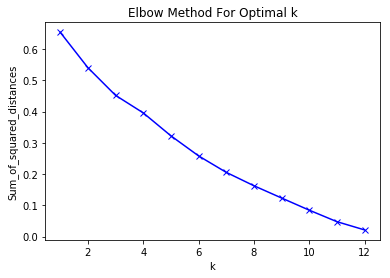

In [94]:
#Checking best K
Sum_of_squared_distances = []
santiago_grouped_clustering_2 = santiago_grouped_2.drop('Neighborhood', 1)
K = range(1,13)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(santiago_grouped_clustering_2)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [102]:
#Start the clustering

# set number of clusters
kclusters = 6

santiago_grouped_clustering_2 = santiago_grouped_2.drop('Neighborhood', 1)

# run k-means clustering
kmeans_2 = KMeans(n_clusters=kclusters, random_state=0).fit(santiago_grouped_clustering_2)

# check cluster labels generated for each row in the dataframe
kmeans_2.labels_[0:10]

array([2, 3, 1, 5, 2, 4, 0, 1, 5, 5], dtype=int32)

In [103]:
# add clustering labels
neighborhoods_venues_sorted_2.insert(0, 'Cluster Labels', kmeans_2.labels_)
santiago_merged_2 = chile_pc_2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
santiago_merged_2 = santiago_merged_2.join(neighborhoods_venues_sorted_2.set_index('Neighborhood'), on='Neighborhood')

santiago_merged_2 # check the last columns!

,Neighborhood,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"La Cisterna, CL",7970000,-33.529522,-70.664253,2,Chinese Restaurant,Gym,Sushi Restaurant,Pizza Place,Bakery,Peruvian Restaurant,Pharmacy,Basketball Court,Fast Food Restaurant,French Restaurant
1,"La Florida, CL",8240000,-33.558781,-70.589114,3,Pharmacy,Liquor Store,Japanese Restaurant,Playground,Pool,Metro Station,Bar,Bakery,Nightclub,Food Stand
2,"Las Condes, CL",7550000,-33.407949,-70.545113,1,Arts & Crafts Store,Grocery Store,Pharmacy,Plaza,Italian Restaurant,Bus Station,Restaurant,Bakery,Pizza Place,Japanese Restaurant
3,"Lo Barnechea, CL",7690000,-33.353468,-70.522224,5,Gym,Pizza Place,BBQ Joint,Other Great Outdoors,Pet Store,Burger Joint,Diner,Sandwich Place,Shopping Mall,Bakery
4,"Lo Prado, CL",8980000,-33.447044,-70.723399,2,Sushi Restaurant,Pharmacy,Wings Joint,Food Truck,Nightclub,Convenience Store,Bus Station,Farmers Market,Bakery,Chinese Restaurant
5,"Macul, CL",7810000,-33.491943,-70.599732,4,Restaurant,Pharmacy,Plaza,Seafood Restaurant,Pizza Place,Bakery,Miscellaneous Shop,Convenience Store,Sushi Restaurant,Gym / Fitness Center
6,"Ñuñoa, CL",7750000,-33.454330,-70.600582,1,Sandwich Place,Bakery,Sushi Restaurant,Middle Eastern Restaurant,Yoga Studio,Chinese Restaurant,Pastry Shop,Burger Joint,Music Store,Cheese Shop
7,"Peñalolén, CL",7910000,-33.476482,-70.544581,0,Pharmacy,Gym / Fitness Center,Fast Food Restaurant,Soccer Field,Coffee Shop,Pizza Place,Sushi Restaurant,Park,Convention Center,Pool
8,"Providencia, CL",7500000,-33.428838,-70.611337,1,Restaurant,Café,Bakery,Coffee Shop,Pizza Place,Spa,Venezuelan Restaurant,Yoga Studio,Building,Peruvian Restaurant
9,"Puente Alto, CL",8150000,-33.609528,-70.575474,5,Jewelry Store,Gym,Seafood Restaurant,Convenience Store,Burger Joint,Diner,Pharmacy,Pizza Place,Boutique,Plaza


In [105]:
# Create map of Santiago City centered in the Santiago neighborhood
latitude = chile_pc.at[26,'Latitude']
longitude = chile_pc.at[26,'Longitude']
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(santiago_merged_2['Latitude'], santiago_merged_2['Longitude'], santiago_merged_2['Neighborhood'], santiago_merged_2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters